<a href="https://colab.research.google.com/github/yepe4401/GAN_Monet/blob/main/Copy_of_GAN_Monet_YP_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --upgrade fastai
!pip install --upgrade wandb
!pip install --upgrade torch
!pip install git+https://github.com/tmabraham/UPIT.git

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [9]:
!pip install upit


In [10]:
from upit.data.unpaired import *
from upit.models.cyclegan import *
from upit.train.cyclegan import *
from upit.inference.cyclegan import *
from upit.metrics import *
from upit.tracking.wandb import *
from fastai.vision.all import *
import wandb

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


# Photo To Monet Painting using GAN

In this assignemnet we have a dataset of photos of various scenary and some paintings of the artist Monet. The goal is to train a GAN to convert photos to paintings in the style of Monet.

Lets first load and look at the data

In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd /content/drive/My Drive

/content/drive/My Drive


In [18]:
photo2monet = Path('./gan-getting-started')
trainA_path = photo2monet/'photo_jpg'
trainB_path = photo2monet/'monet_jpg'
print(f"There are {len(trainA_path.ls())} photos")
print(f"There are {len(trainB_path.ls())} Monet paintings")

There are 7038 photos
There are 300 Monet paintings


The training data has 7038 photos and 300 Monet paintings which can be used to train the GAN.

Lets use the UPIT toolkit to create a data structure (denoted by dls below) suitable for the cycle GAN learner function and show a few images from the dls data structure

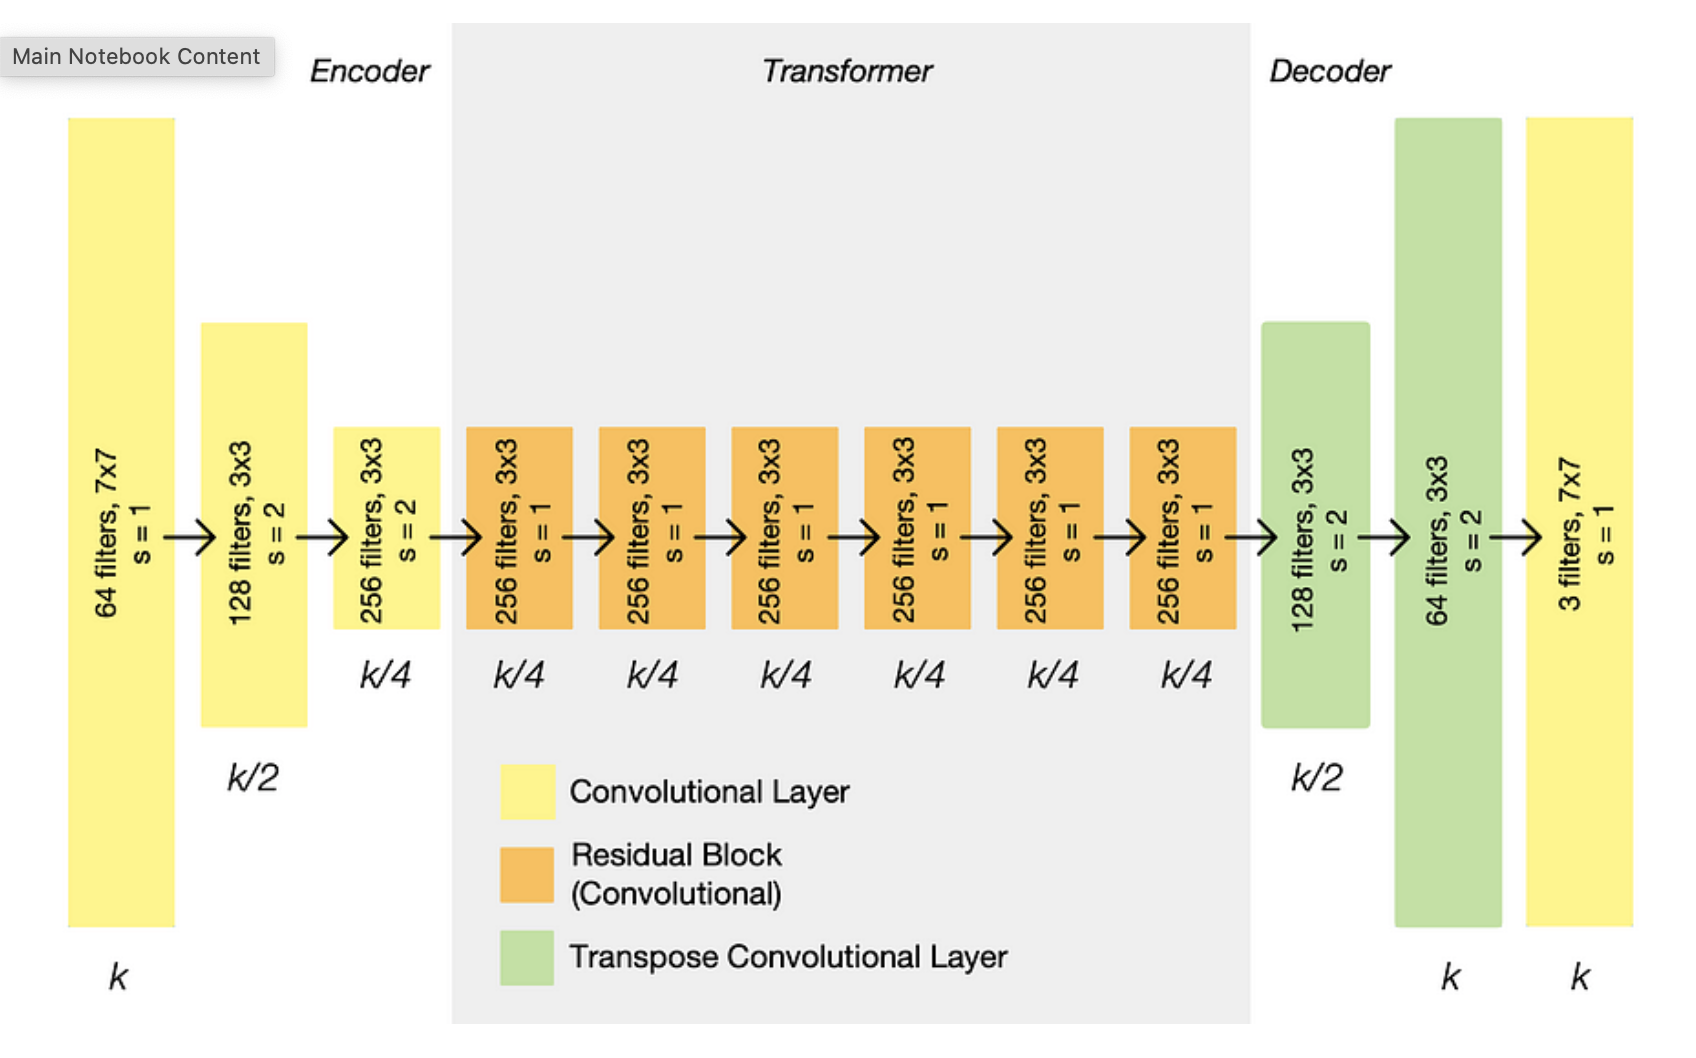


@Misc{UPIT,
    author =       {Tanishq Mathew Abraham},
    title =        {UPIT - A fastai/PyTorch package for unpaired image-to-image translation.},
    howpublished = {Github},
    year =         {2021},
    url =          {https://github.com/tmabraham/UPIT}
}

In [19]:
dls = get_dls(trainA_path, trainB_path,load_size=256,crop_size=256)

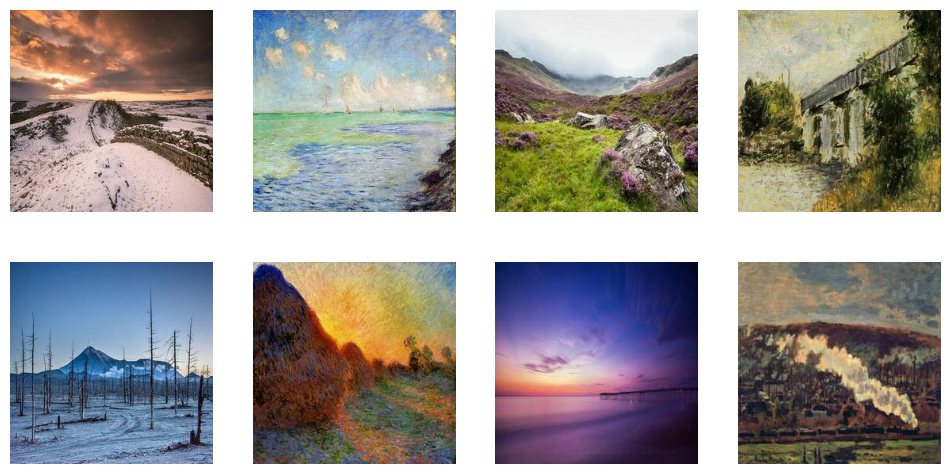

In [20]:
dls.show_batch()

## Model Architecture


We will use a cycle-GAN or cycle-consistent GAN. This type of GAN is especially well suited for this task of Un-Paired Image Translation (UPIT). This is due to the fact that the cycle GAN minmizes the cycle loss of translation from domain A (e.g photos in our case) to domain B (e.g Monet style painting) and then back to domain A
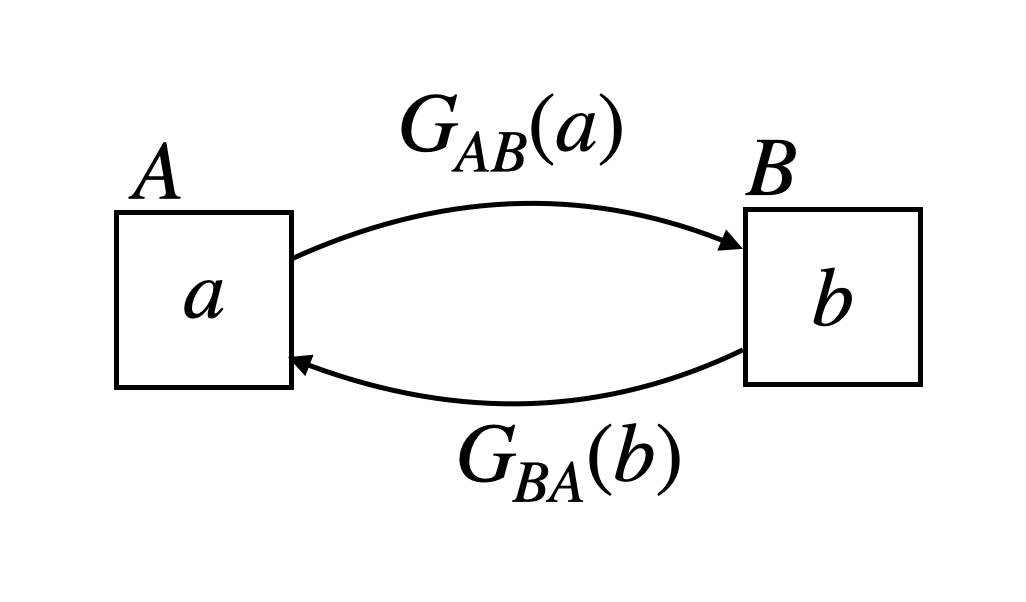


The Cycle GAN loss function will make the mapping $$ G_{AB}(G_{BA}(b)) \approx a $$ and $$ G_{BA}(G_{AB}(a)) \approx b $$

where $$ a,b $$ are images (or other objects) from domains $$ A,B $$ respectively.

The image below shows a summary of how the cycle GAN generators and discrimitaors work together to achieve this on an example of translating from horses to zebras



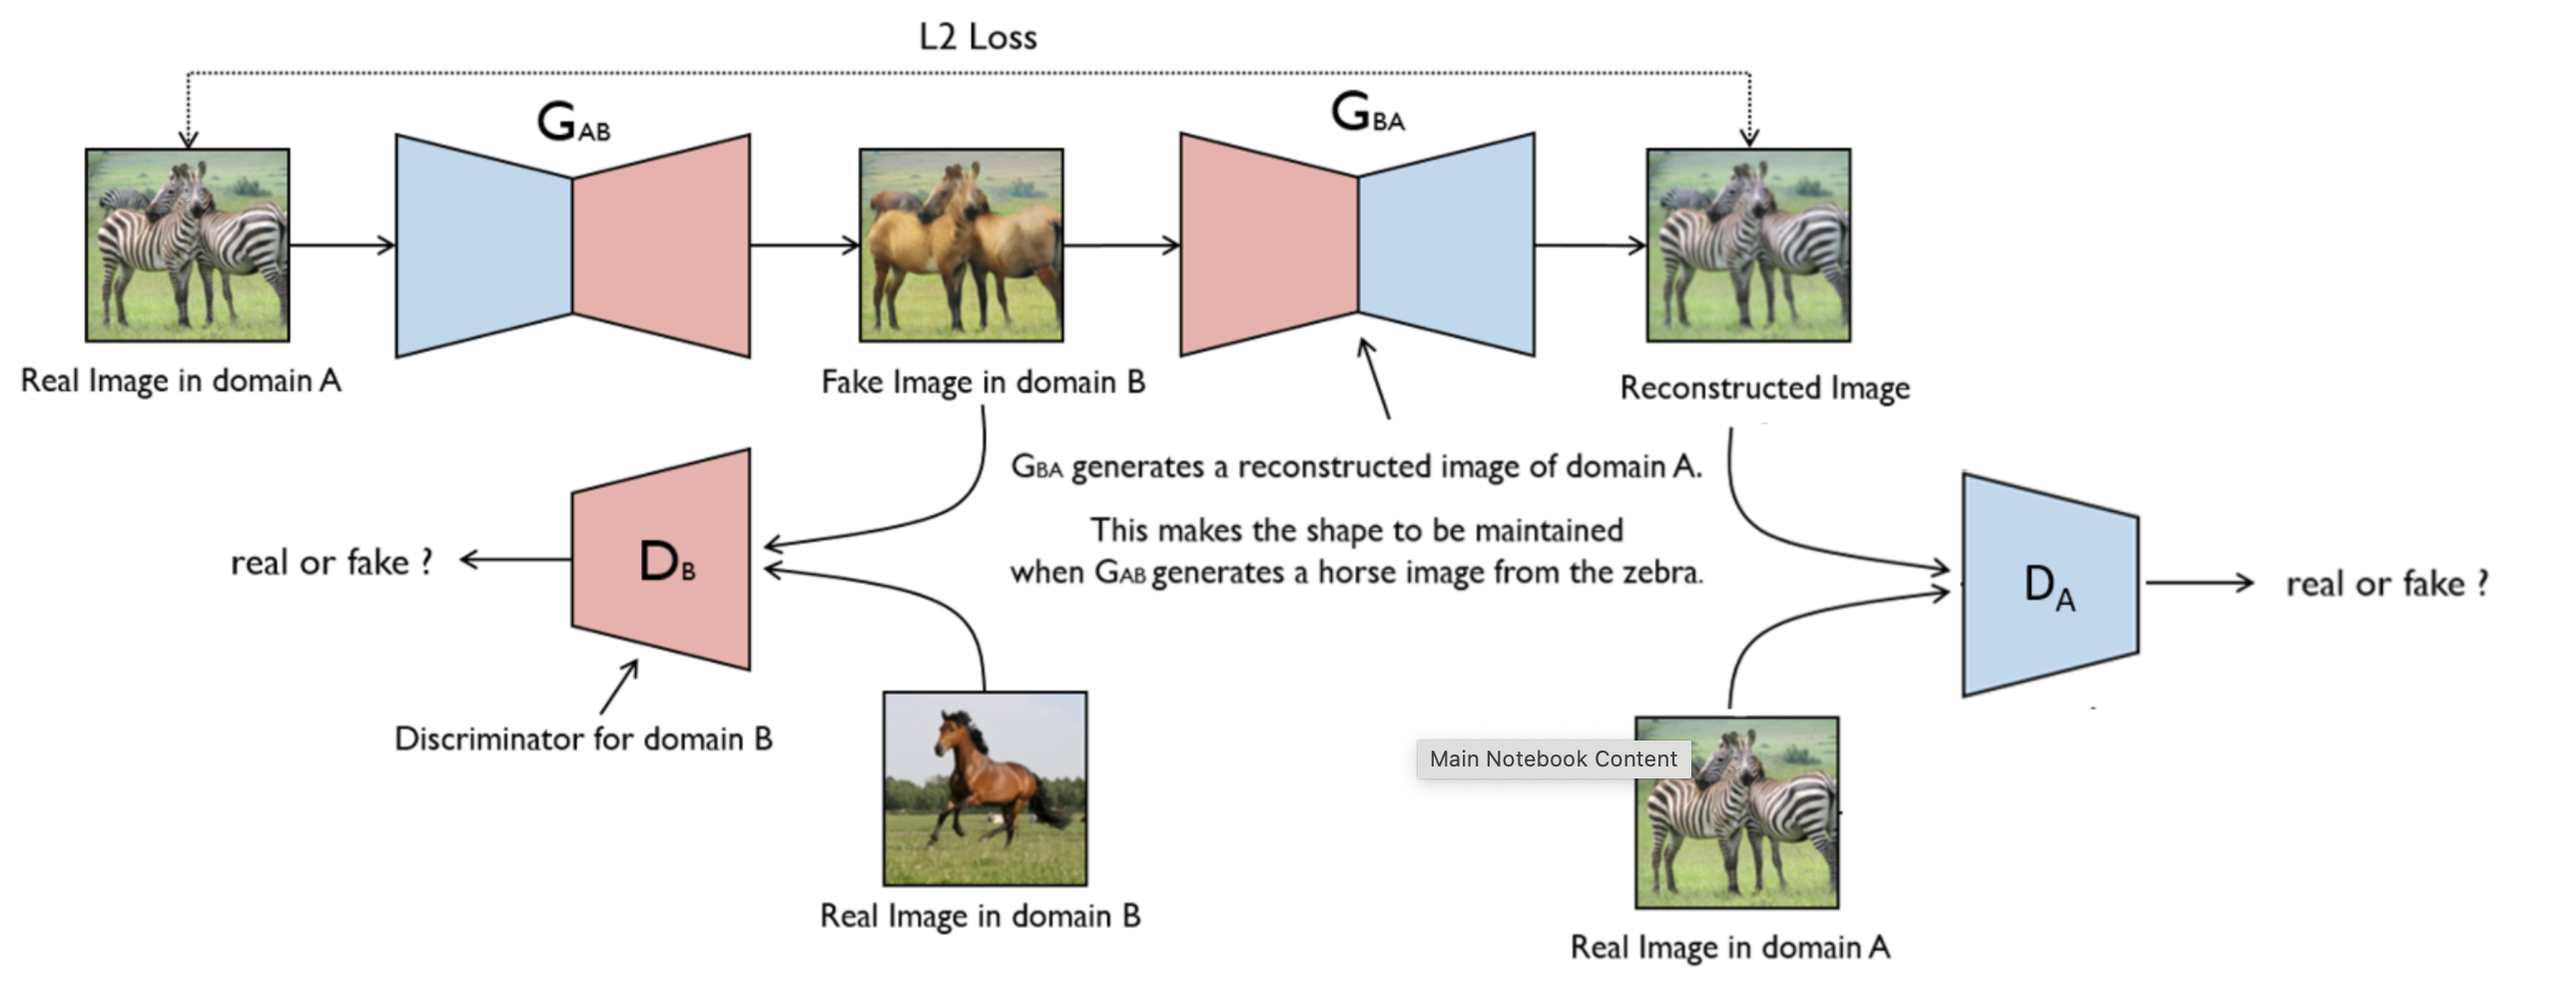


The generator uses the following ResNet arch

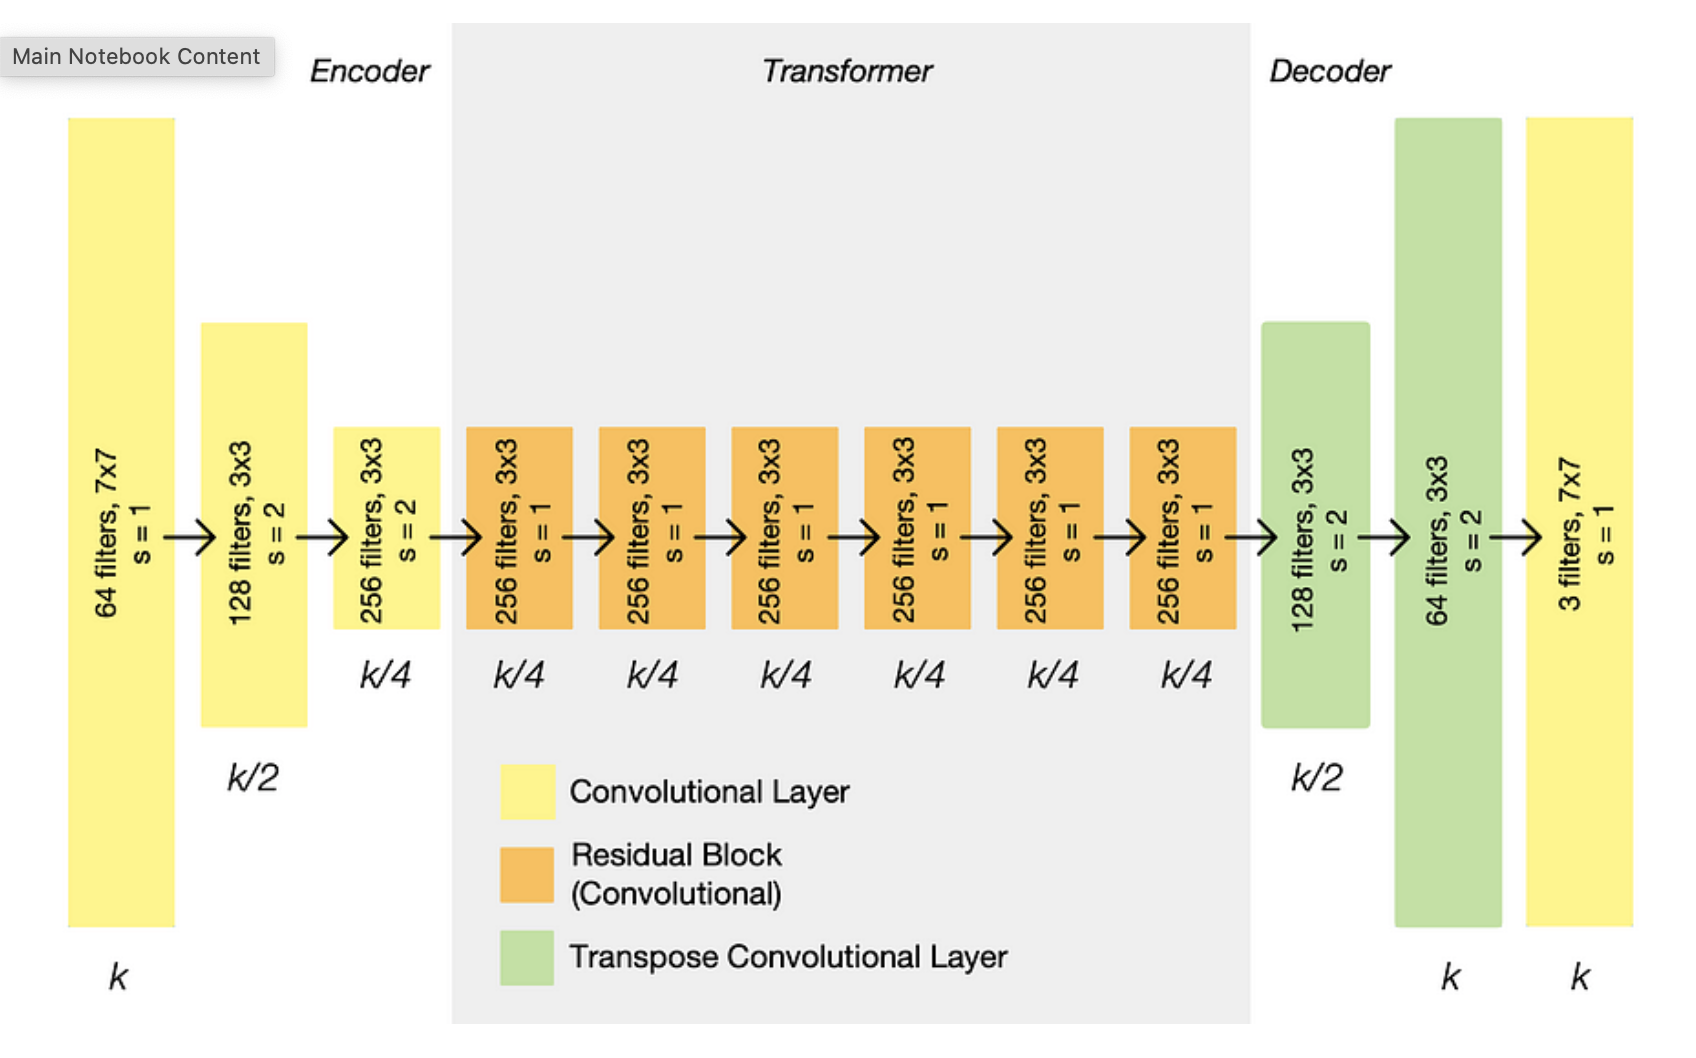

The discriminator uses the following PatchGAN arch

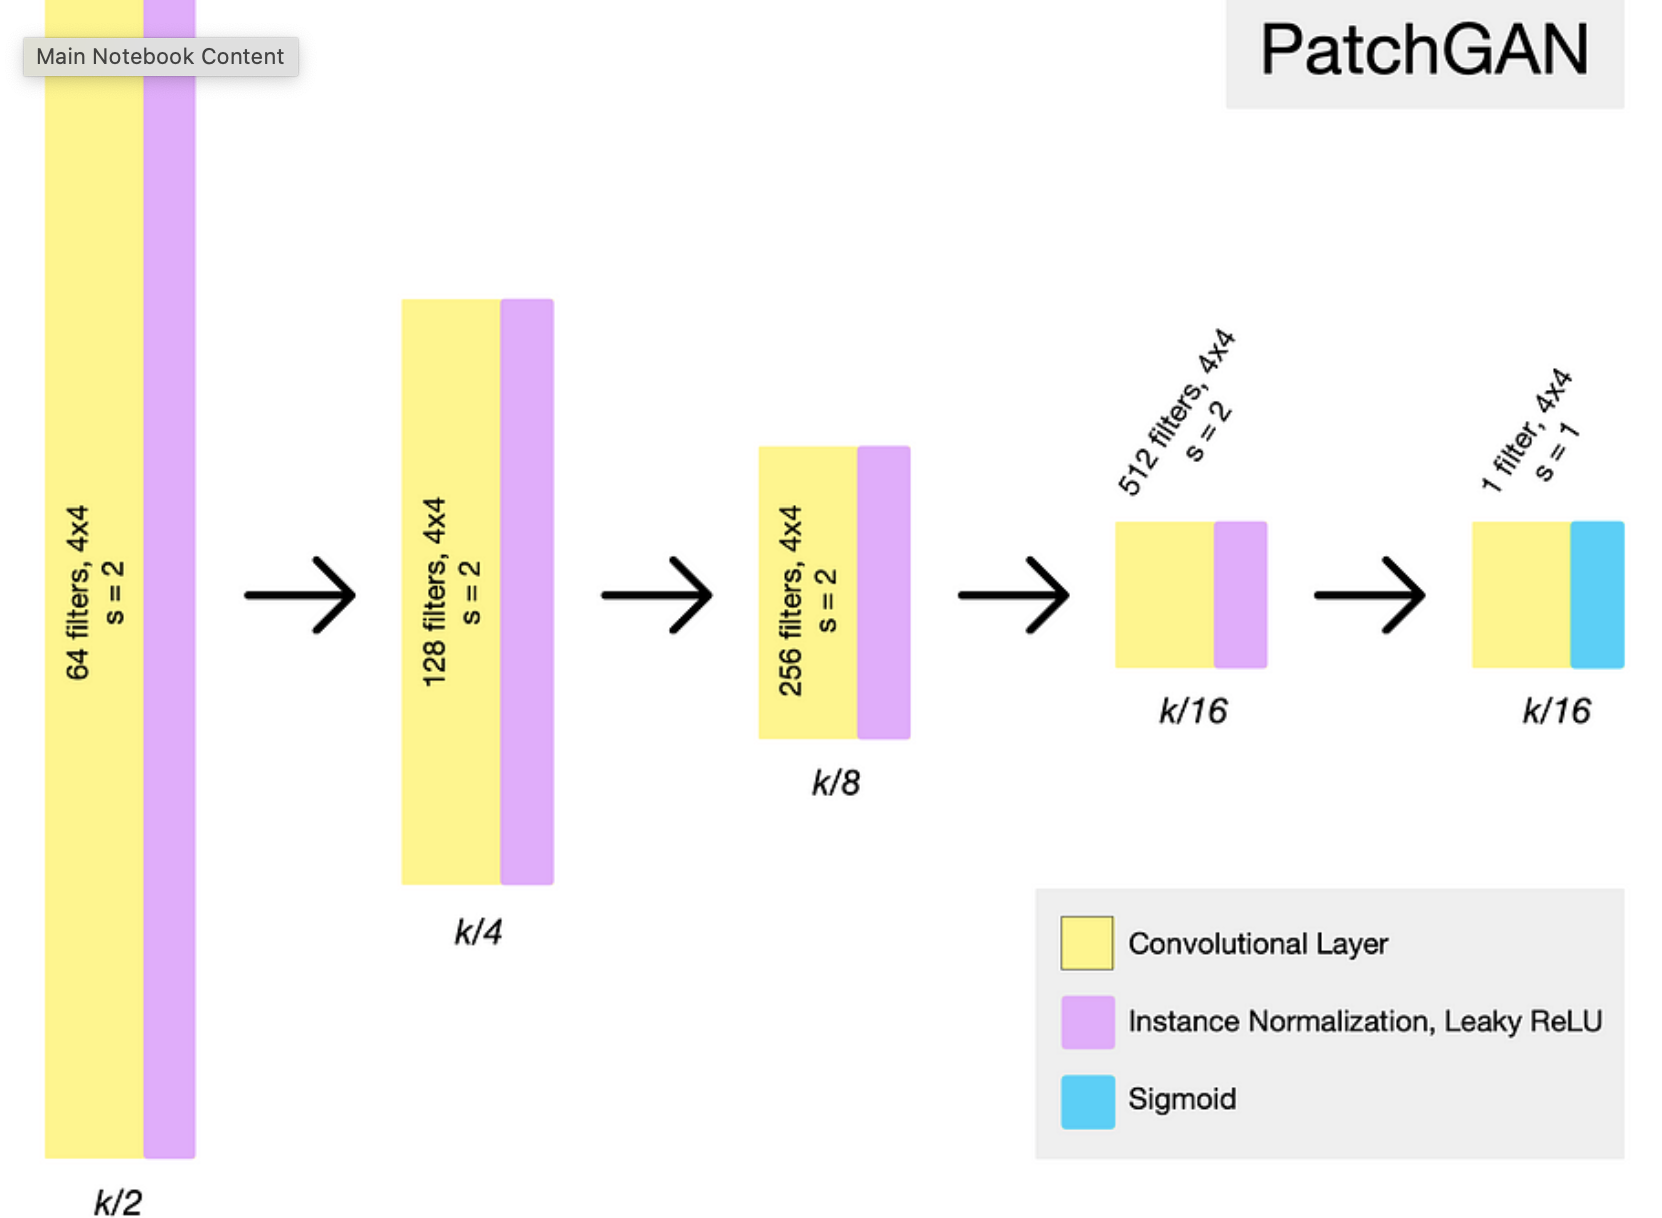

In [21]:
cycle_gan = CycleGAN(3,3,64,gen_blocks=3)

In [22]:
learn = cycle_learner(dls, cycle_gan,opt_func=partial(Adam,mom=0.5,sqr_mom=0.999),show_img_interval=8)

We can sweep across different learning rates to find a somewhat optimal one


SuggestedLRs(valley=1.737800812406931e-05)

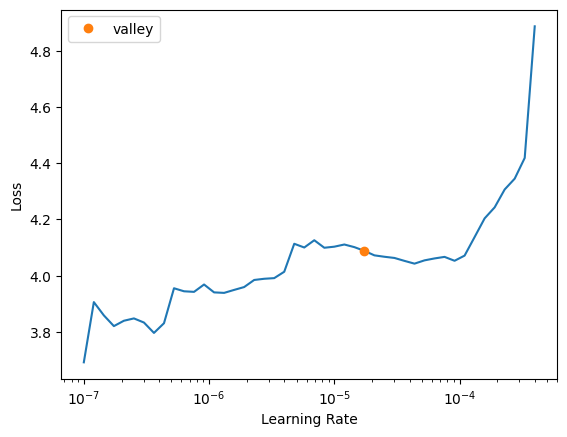

In [59]:
learn.lr_find()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


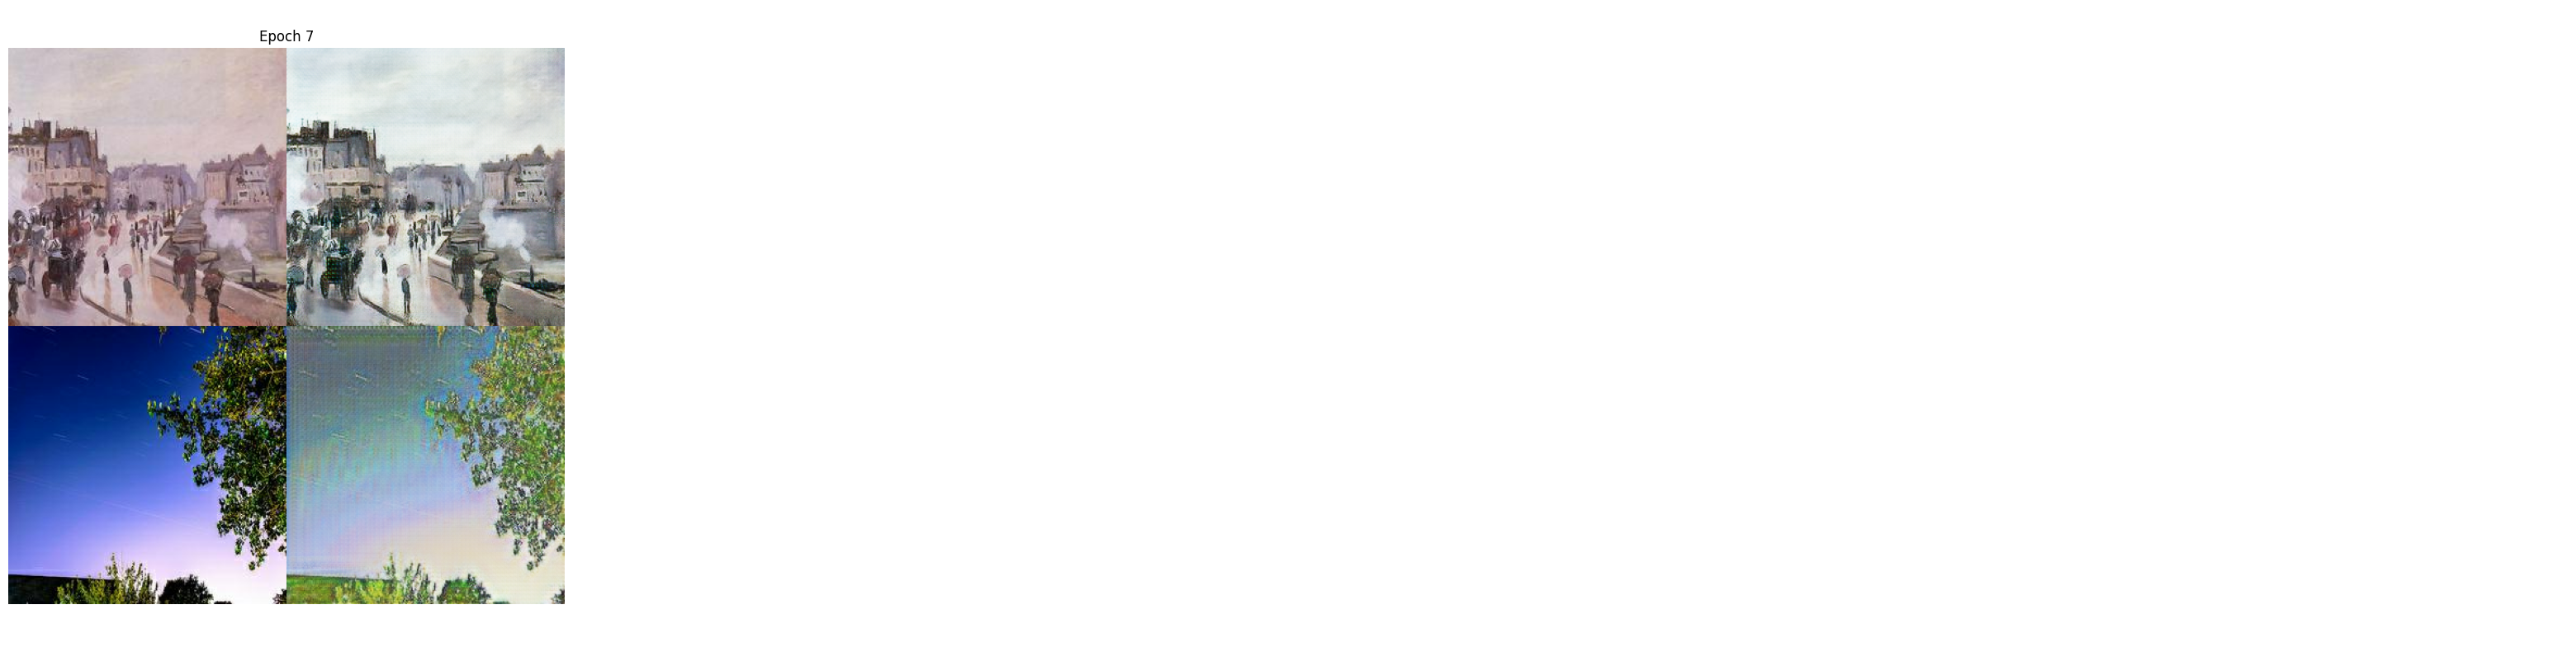

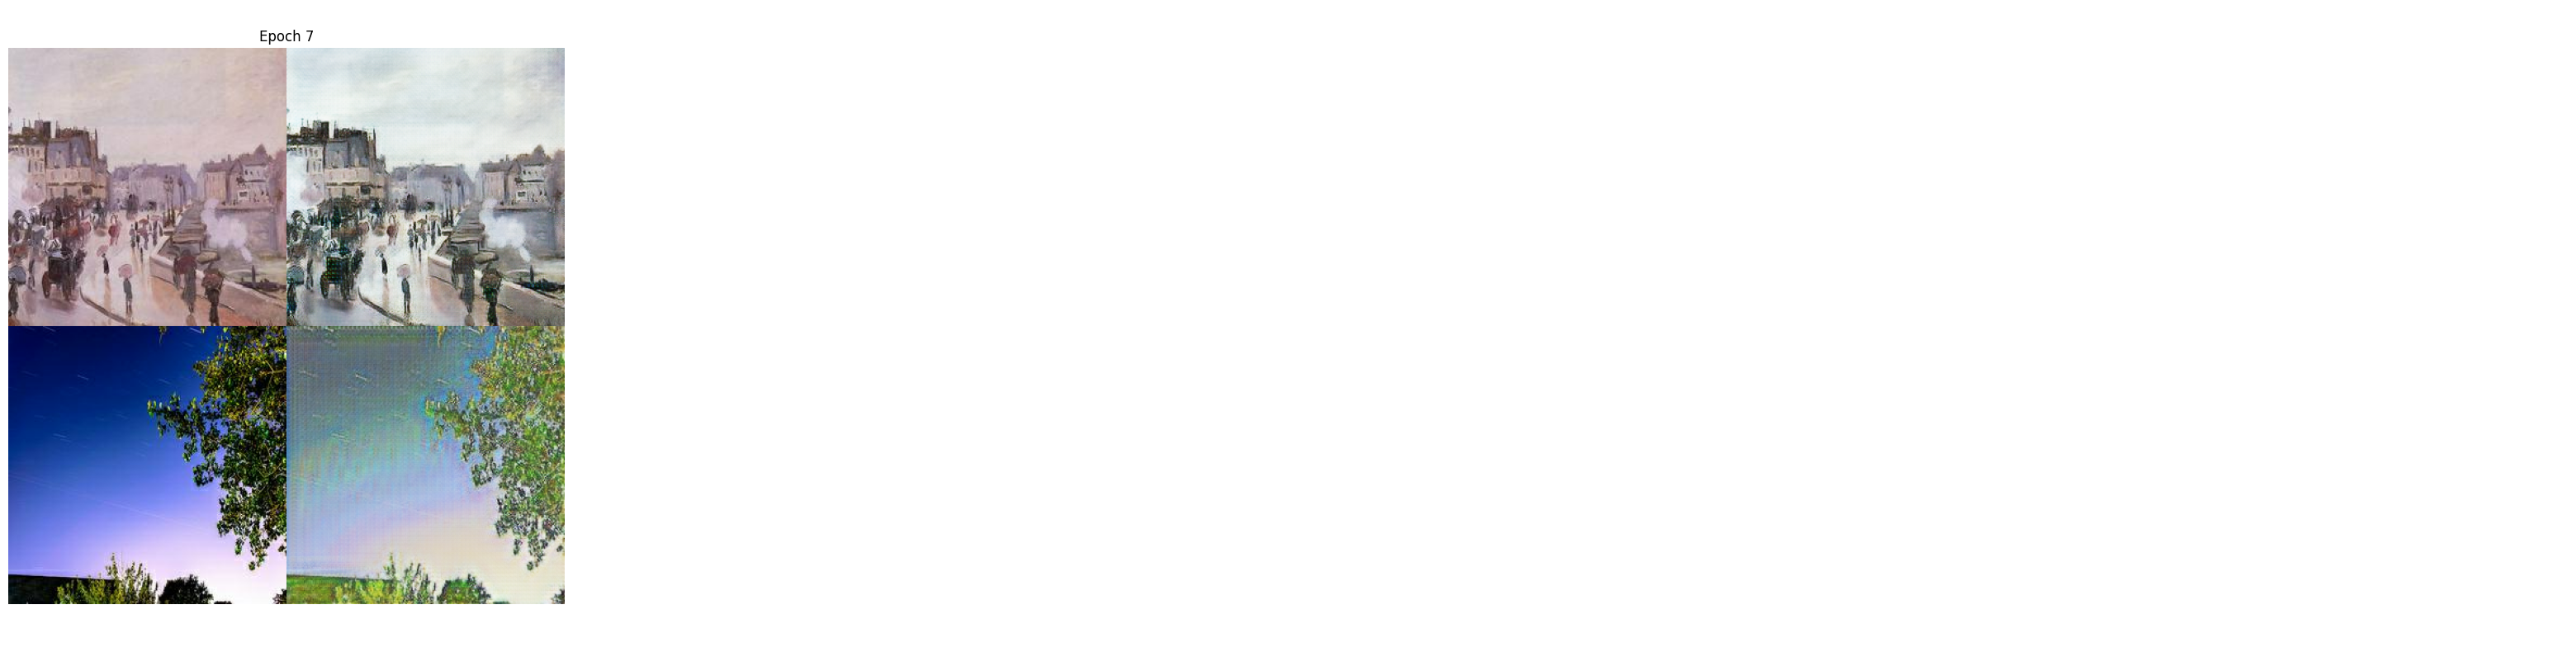

In [23]:
learn.fit_flat_lin(7,7,2e-4)

Lets now generate the predictions or Monet style paintings for all the photos in the data set

In [55]:
testA_path = './gan-getting-started/photo_jpg/'
pred_path = './gan-getting-started/generated_images/'

In [56]:
print(pred_path)
print(testA_path)


./gan-getting-started/generated_images/
./gan-getting-started/photo_jpg/


In [57]:
get_preds_cyclegan(learn,testA_path,pred_path,suffix='jpg')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Lets look at some of the images

./gan-getting-started/generated_images//99a6c4d326_fakeB.jpg
./gan-getting-started/generated_images//15a51e4dbe_fakeB.jpg
./gan-getting-started/generated_images//0f1e6530bc_fakeB.jpg
./gan-getting-started/generated_images//bb40b8dd7f_fakeB.jpg
./gan-getting-started/generated_images//67cb59fe1b_fakeB.jpg


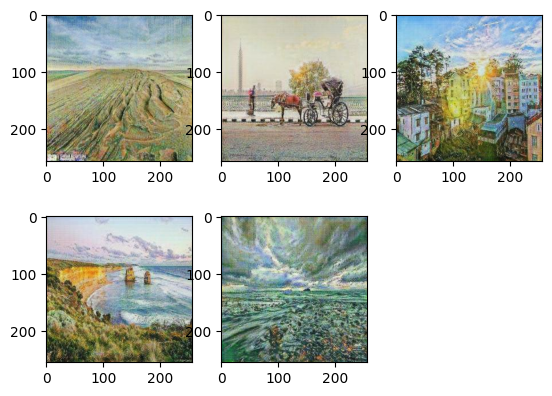

In [78]:
import matplotlib.image as mpimg
i=1;
plt.figure()
for file in os.listdir(pred_path)[0:5]:
        fullpath = pred_path+ "/" + file
        print(fullpath)
        img=mpimg.imread(fullpath)
        plt.subplot(2,3,i)
        plt.imshow(img)
        i=i+1

## Conclusion

We saw that using the Cycle GAN is a very attractive architecture for this kind of problem. The generated images look quite realistic. learnign rate optimization showed a learning rate in teh range of 1e-4 to 1e-5 is the best.